In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. Custom Feedback Alignment with Sparsity Mask
class FA_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias, B):
        ctx.save_for_backward(input, weight, bias, B)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias, B = ctx.saved_tensors
        grad_weight = grad_output.t().mm(input)
        grad_bias = grad_output.sum(0) if bias is not None else None
        
        # Backward signal sent through the sparse random matrix B
        grad_input = grad_output.mm(B) 
        return grad_input, grad_weight, grad_bias, None

class SparseFALinear(nn.Module):
    def __init__(self, in_features, out_features, sparsity=0.0):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.B = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=False)
        
        # Initialize
        nn.init.uniform_(self.weight, -0.1, 0.1)
        nn.init.uniform_(self.bias, -0.1, 0.1)
        nn.init.uniform_(self.B, -0.5, 0.5)
        
        # --- THE INNOVATION: Apply Sparsity Mask to B ---
        if sparsity > 0:
            # Fixed the typo here: rand_like instead of rand_as
            mask = (torch.rand_like(self.B) > sparsity).float()
            self.B.data *= mask 
            
    def forward(self, x):
        return FA_Function.apply(x, self.weight, self.bias, self.B)

In [ ]:
# 2. Model Structure (784 -> 1000 -> 10)
class RobustModel(nn.Module):
    def __init__(self, sparsity):
        super().__init__()
        self.fc1 = SparseFALinear(784, 1000, sparsity=sparsity)
        self.fc2 = SparseFALinear(1000, 10, sparsity=sparsity)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [ ]:
# 3. Training Function
def train_robustness(sparsity_level):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RobustModel(sparsity=sparsity_level).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Standard MNIST Loader
    train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, 
                              transform=transforms.ToTensor()), batch_size=128, shuffle=True)
    test_loader = DataLoader(datasets.MNIST('./data', train=False, 
                             transform=transforms.ToTensor()), batch_size=1000)

    test_errors = []
    print(f"\nTraining with {int(sparsity_level*100)}% Sparsity (Dead Connections)...")

    for epoch in range(10): 
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            # One-hot encoding
            target_onehot = torch.zeros(target.size(0), 10).to(device).scatter_(1, target.view(-1, 1), 1.0)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target_onehot)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        err = 100. - (100. * correct / len(test_loader.dataset))
        test_errors.append(err)
        print(f"  Epoch {epoch+1}: Error {err:.2f}%")
        
    return test_errors

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 417kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.96MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.17MB/s]



Training with 0% Sparsity (Dead Connections)...
  Epoch 1: Error 9.61%
  Epoch 2: Error 7.40%
  Epoch 3: Error 6.38%
  Epoch 4: Error 5.67%
  Epoch 5: Error 4.96%
  Epoch 6: Error 4.42%
  Epoch 7: Error 4.03%
  Epoch 8: Error 3.71%
  Epoch 9: Error 3.58%
  Epoch 10: Error 3.13%

Training with 50% Sparsity (Dead Connections)...
  Epoch 1: Error 9.57%
  Epoch 2: Error 7.56%
  Epoch 3: Error 6.57%
  Epoch 4: Error 5.57%
  Epoch 5: Error 5.03%
  Epoch 6: Error 4.54%
  Epoch 7: Error 4.06%
  Epoch 8: Error 3.95%
  Epoch 9: Error 3.37%
  Epoch 10: Error 3.22%

Training with 95% Sparsity (Dead Connections)...
  Epoch 1: Error 10.82%
  Epoch 2: Error 8.98%
  Epoch 3: Error 7.87%
  Epoch 4: Error 7.12%
  Epoch 5: Error 6.85%
  Epoch 6: Error 5.98%
  Epoch 7: Error 5.60%
  Epoch 8: Error 5.18%
  Epoch 9: Error 4.61%
  Epoch 10: Error 4.34%

Training with 99% Sparsity (Dead Connections)...
  Epoch 1: Error 13.42%
  Epoch 2: Error 9.78%
  Epoch 3: Error 8.67%
  Epoch 4: Error 8.09%
  Epoch 5: Err

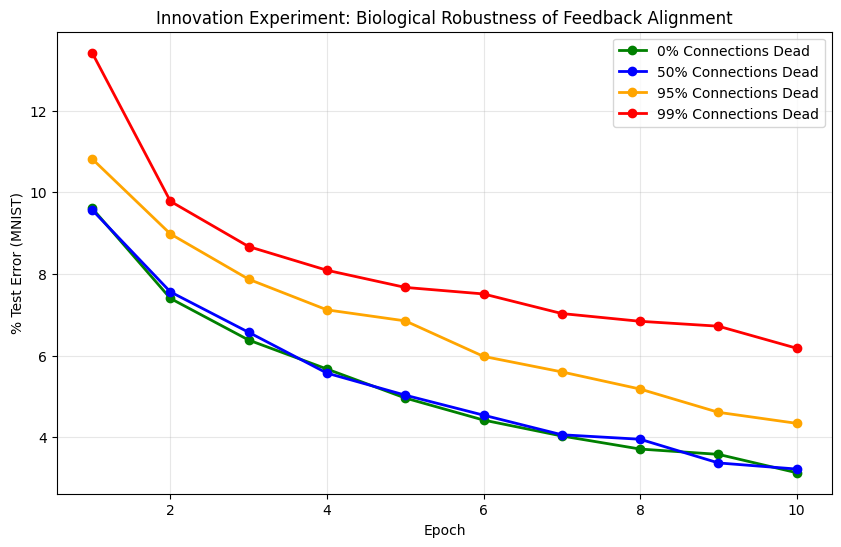

In [12]:
# 4. Run the Experiment
sparsity_levels = [0.0, 0.50, 0.95, 0.99]
results = {}

for s in sparsity_levels:
    results[s] = train_robustness(s)

# 5. Plotting the Results
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'red']

for i, s in enumerate(sparsity_levels):
    plt.plot(range(1, 11), results[s], label=f"{int(s*100)}% Connections Dead", 
             color=colors[i], marker='o', linewidth=2)

plt.title("Innovation Experiment: Biological Robustness of Feedback Alignment")
plt.xlabel("Epoch")
plt.ylabel("% Test Error (MNIST)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()